# VGG16 - AI Lab - PSS One Page

In [1]:
#Experiment Setup
DATA = 'ai_lab_splitter'
INPUT_DIM = 1
OUTPUT_DIM = 2
OUTPUT_METRIC = 2
NN = 'VGG16'
PRE_PROCESS = ''
POS_PROCESS = ''
EXPERIMENT = f'{DATA}_input_{INPUT_DIM}_classes_{OUTPUT_DIM}_nn_{NN}'
if PRE_PROCESS != '':
    EXPERIMENT += f'_PRE_{PRE_PROCESS}'
if POS_PROCESS != '':
    EXPERIMENT += f'_POS_{POS_PROCESS}'
print(EXPERIMENT)

ai_lab_splitter_input_1_classes_2_nn_VGG16


### Data Processing

As always, we'll import the modules we need. No new imports yet.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import numpy as np

import timm
from timm.optim import optim_factory

from types import SimpleNamespace

import torchvision.transforms as transforms

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt

import copy
import random
import time

import pandas as pd

import math

import cv2
import base64
import numpy as np

from utils import concat_three_images, normalize_image, plot_one_image, epoch_time, export_report
from nn_modules import OnePageVGG16Module
from dataset_modules import ResizeBinarizeVGG, AILabDatasetOne

We'll also set the random seeds.

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Defining the Model

Here we define a model 

In [4]:
model = OnePageVGG16Module(OUTPUT_DIM)

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 138,980,074 trainable parameters


### Data Processing

In [6]:

transform = transforms.Compose([
                            ResizeBinarizeVGG(),
                            #transforms.Resize(pretrained_size),
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: torch.cat([x, x, x], 0))
                            #transforms.Normalize(mean = pretrained_means, std = pretrained_stds)
                       ])

Setting the path of images and csvs

pretrained_size = (224,224)
 transforms.Resize(pretrained_size),

Loading datasets

In [7]:
TRAIN_DATA_PATH = '/mnt/nas/victor_splitter/data/isjeaai/df_train.parquet.gzip'  
VALID_DATA_PATH = '/mnt/nas/victor_splitter/data/isjeaai/df_val.parquet.gzip'
TEST_DATA_PATH = '/mnt/nas/victor_splitter/data/isjeaai/df_test.parquet.gzip'

In [8]:
df_train = pd.read_parquet(TRAIN_DATA_PATH)
df_val = pd.read_parquet(VALID_DATA_PATH)
df_test = pd.read_parquet(TEST_DATA_PATH)

In [9]:
label2Idx = {'FirstPage' : 1, 'NextPage' : 0}

In [10]:
train_data = AILabDatasetOne(df_train, 'class', transform )

valid_data = AILabDatasetOne(df_val, 'class', transform )

test_data = AILabDatasetOne(df_test, 'class', transform )

We'll print out the number of examples in each split to ensure they are correct.

In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of test examples: {len(test_data)}')

Number of training examples: 20534
Number of validation examples: 5134
Number of test examples: 6121


Number of training examples: 20181
Number of validation examples: 5513
Number of test examples: 6095

We'll also plot out a few images to ensure the transformations look sensible - making sure to re-normalize our data so we can view it with the correct colors.

As we can see, the larger images mean we can get away with larger amounts of rotation and cropping with the images still looking reasonable.

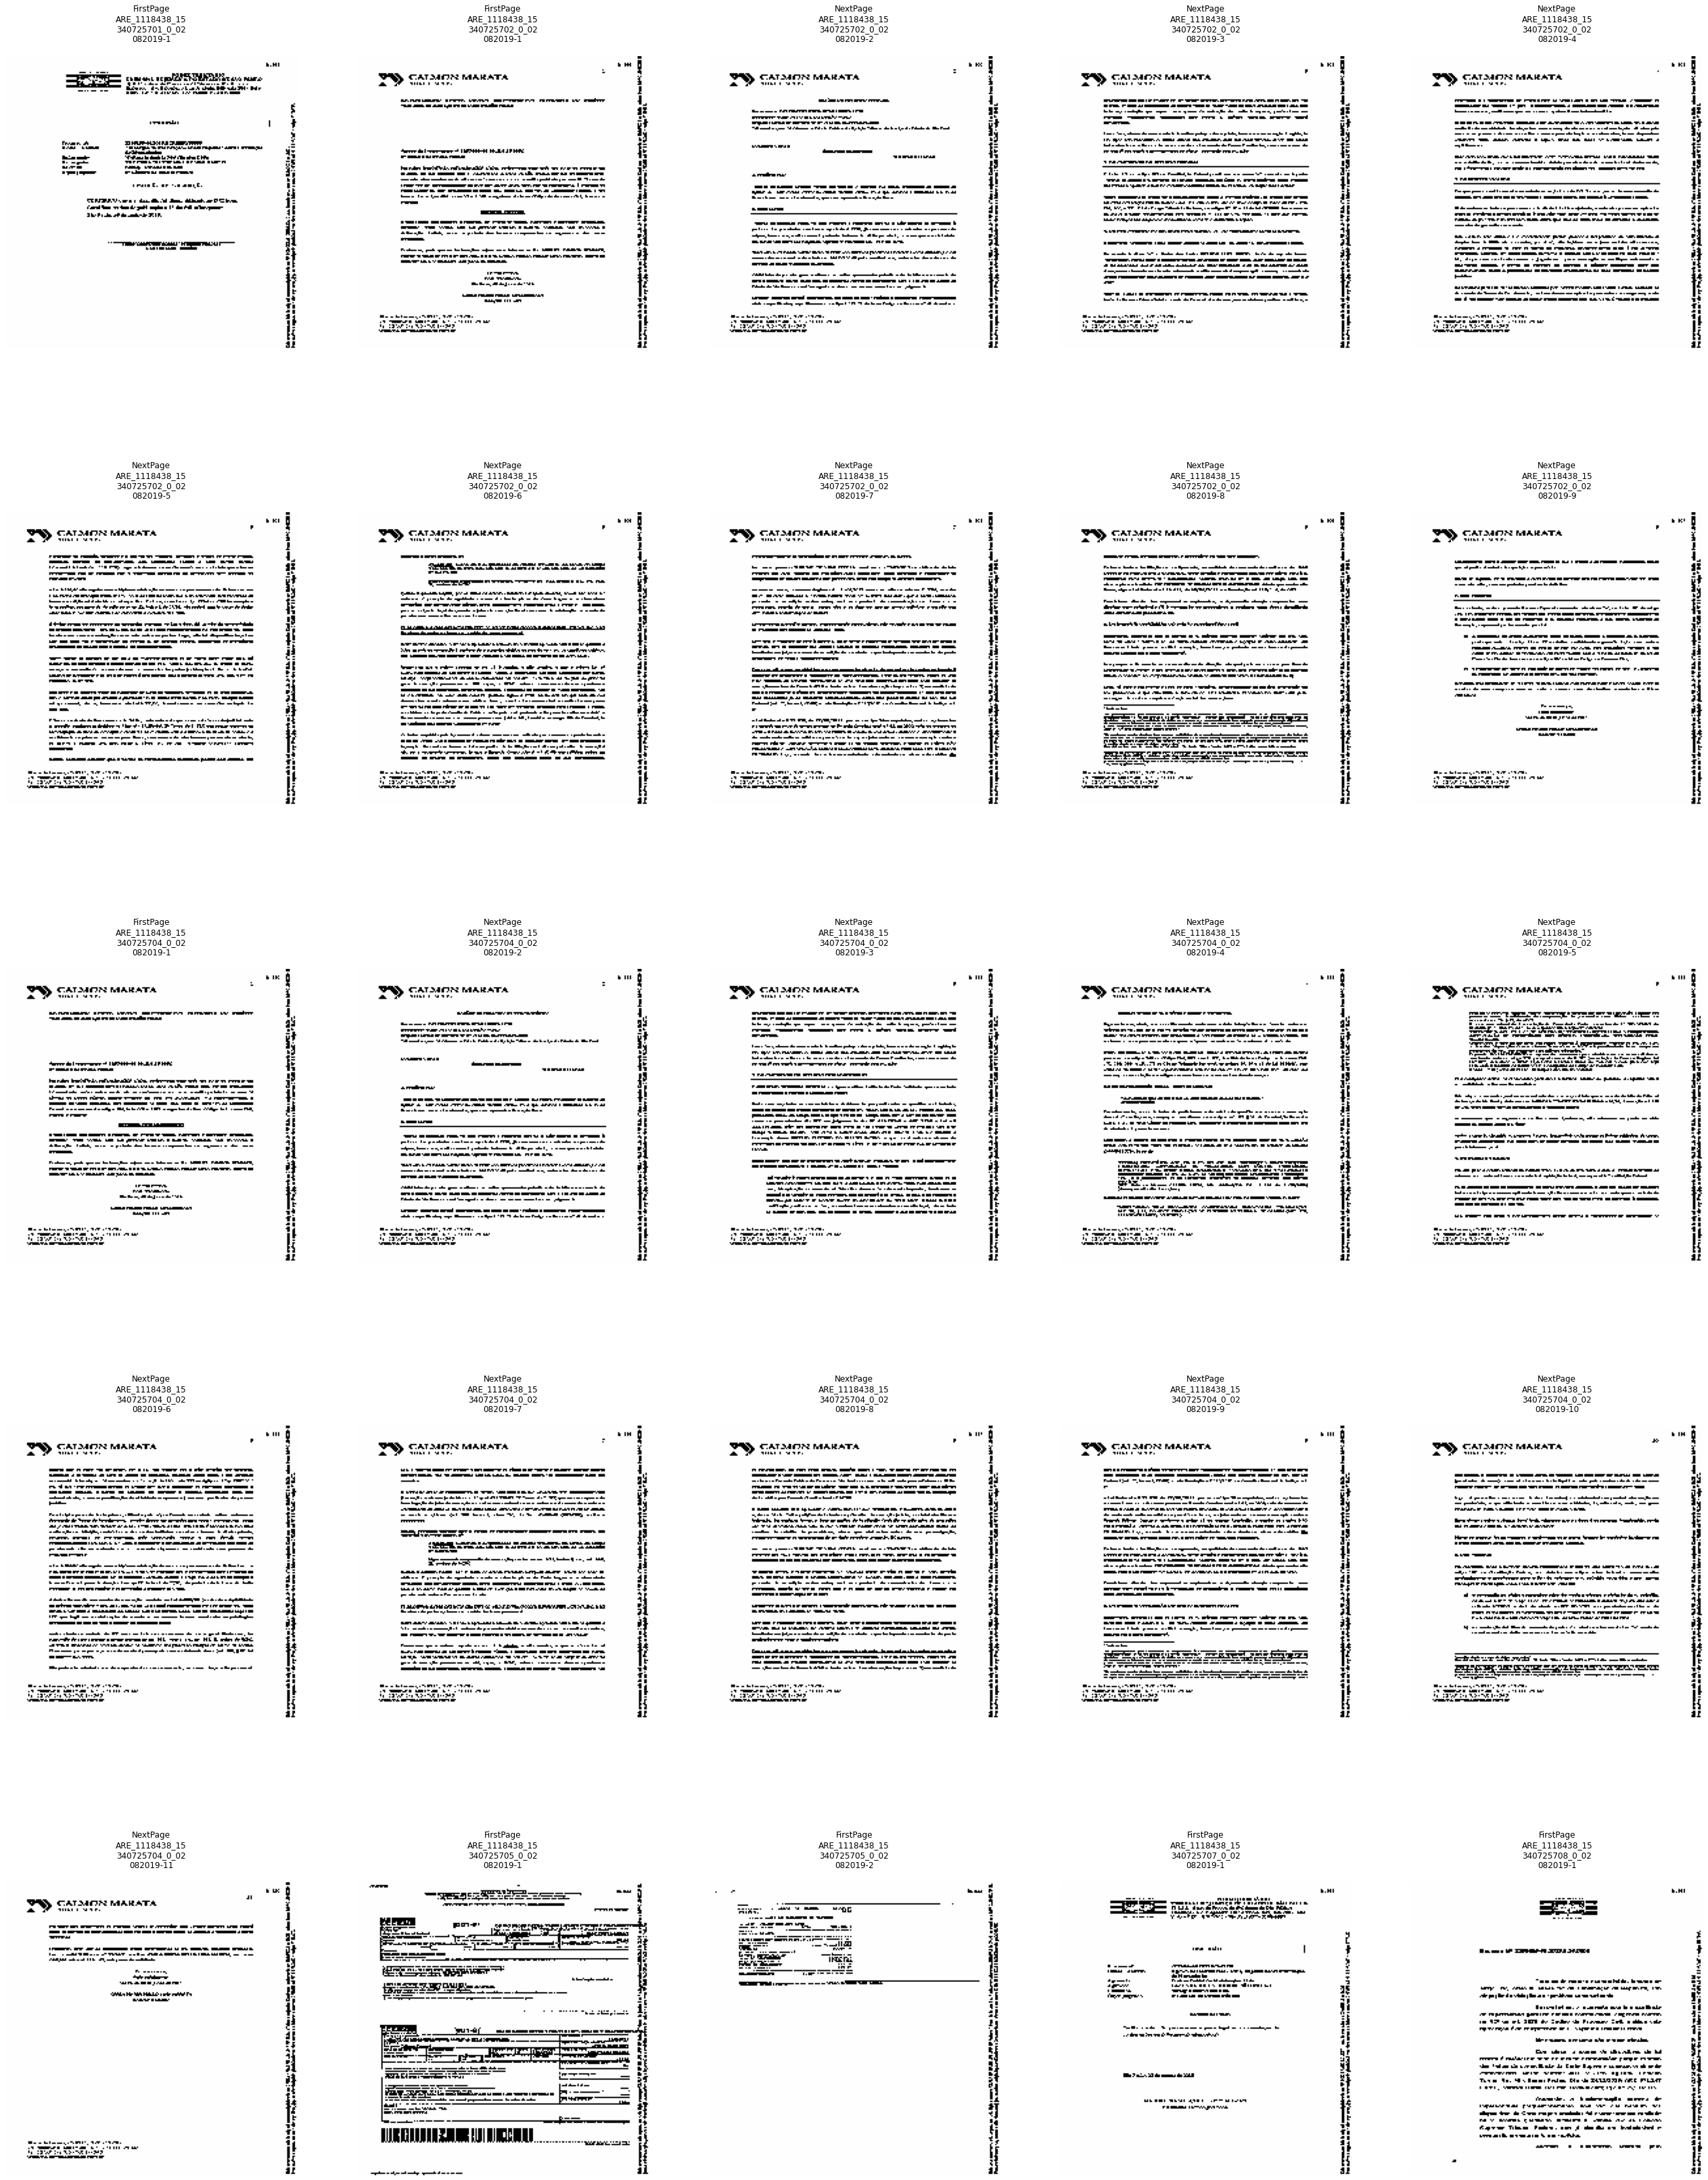

In [12]:
N_IMAGES = 25

images, labels, file_names = zip(*[(image, label, file_name) for image, label, file_name in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = {1: 'FirstPage', 0: 'NextPage'}

plot_one_image(images, labels, classes, file_names)

As the model is ~5x the size of the AlexNet model from the previous notebook we use a smaller batch size so it can fit on reasonably sized GPUs. This should be increased if we have access to GPUs with more memory in order to speed up training.

In [13]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, 
                                 batch_size = BATCH_SIZE)

### Training the Model

We'll use the learning rate finder as used in previous notebooks. Generally when using a pre-trained model the learning rate used will be considerably lower.

First, we'll set up the optimizer with the initial learning rate that is much lower than we expect to use. Then we define the `device` to place our model on our GPU, if we have one. Next we define the `criterion` (loss function) and place the model and criterion on our device.

In [14]:
args = SimpleNamespace()
args.weight_decay = 0 
args.lr = 0.00005
args.opt="Nadam"

optimizer = optim_factory.create_optimizer(args,model)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)

model = model.to(device)
criterion = criterion.to(device)

In [15]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

...create a function that implements a training loop...

In [16]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.train()
    
    for (x, y, name) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        top_pred = y_pred.argmax(1, keepdim = True)
        
        kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().tolist())
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_kappa += 1.0 if math.isnan(kappa) else kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

...create a function that performs an evaluation loop...

In [17]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_kappa = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y, name) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            top_pred = y_pred.argmax(1, keepdim = True)
        
            kappa = cohen_kappa_score(y.tolist(), top_pred.flatten().tolist())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_kappa += 1.0 if math.isnan(kappa) else kappa
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_kappa / len(iterator)

...and a helper function to tell us how long an epoch takes.

Finally, we train our model.

As our images have been resized to be significantly larger and our model has significantly more parameters training takes considerably longer. However, when performing transfer learning we usually train for significantly less epochs and are still able to achieve much higher accuracy than before.

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
EPOCHS = 10

best_valid_loss = float('inf')

experiment_data = []

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc, train_kappa = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_kappa = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print (f'Winner Epoch: {epoch+1:02}.')
        torch.save(model.state_dict(), './model/'+ EXPERIMENT+ '.pt')
        
    scheduler.step(valid_loss)

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train Kappa: {train_kappa*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Kappa: {valid_kappa*100:.2f}%')

    experiment_data.append([train_loss, valid_loss, train_acc, valid_acc, train_kappa, valid_kappa, start_time, end_time])
    experiment_df = pd.DataFrame(experiment_data,columns=['train_loss','valid_loss','train_acc', 'valid_acc','test_kappa', 'valid_kappa','start', 'end' ])
    experiment_df.to_pickle('./model/'+ EXPERIMENT+ '.pk')

Winner Epoch: 01.
Epoch: 01 | Epoch Time: 2m 52s
	Train Loss: 0.447 | Train Acc: 86.90% | Train Kappa: 24.31%
	 Val. Loss: 0.496 |  Val. Acc: 81.39% |  Val. Kappa: 57.60%
Winner Epoch: 02.
Epoch: 02 | Epoch Time: 2m 52s
	Train Loss: 0.393 | Train Acc: 91.74% | Train Kappa: 59.53%
	 Val. Loss: 0.484 |  Val. Acc: 82.65% |  Val. Kappa: 59.06%
Winner Epoch: 03.
Epoch: 03 | Epoch Time: 2m 53s
	Train Loss: 0.378 | Train Acc: 93.26% | Train Kappa: 65.73%
	 Val. Loss: 0.458 |  Val. Acc: 85.07% |  Val. Kappa: 64.35%
Winner Epoch: 04.
Epoch: 04 | Epoch Time: 2m 51s
	Train Loss: 0.370 | Train Acc: 94.07% | Train Kappa: 69.69%
	 Val. Loss: 0.454 |  Val. Acc: 85.50% |  Val. Kappa: 65.18%
Epoch: 05 | Epoch Time: 1m 57s
	Train Loss: 0.362 | Train Acc: 95.00% | Train Kappa: 74.76%
	 Val. Loss: 0.459 |  Val. Acc: 85.02% |  Val. Kappa: 64.85%
Epoch: 06 | Epoch Time: 1m 59s
	Train Loss: 0.358 | Train Acc: 95.46% | Train Kappa: 77.06%
	 Val. Loss: 0.467 |  Val. Acc: 84.38% |  Val. Kappa: 64.66%
Epoch: 07 

In [20]:
experiment_df = pd.read_pickle('./model/'+ EXPERIMENT+ '.pk')

In [21]:
print(EXPERIMENT)
print(experiment_df.sort_values(by=['valid_loss']).iloc[0])
train_loss, valid_loss, train_acc,valid_acc,train_kappa,valid_kappa, start,end = experiment_df.sort_values(by=['valid_loss']).iloc[0]

ai_lab_splitter_input_1_classes_2_nn_VGG16
train_loss         0.350806
valid_loss         0.452960
train_acc          0.961741
valid_acc          0.857143
test_kappa         0.807234
valid_kappa        0.662401
start          39156.652304
end            39332.707978
Name: 7, dtype: float64


In [22]:
model.load_state_dict(torch.load('./model/'+ EXPERIMENT+ '.pt'))

test_loss, test_acc, test_kappa= evaluate(model, test_iterator, criterion, device)

print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}% |  Test. Kappa: {test_kappa*100:.2f}%')

	 Test. Loss: 0.448 |  Test. Acc: 86.29% |  Test. Kappa: 67.58%


### Examining the Model

We'll do the same examinations on the model as we have done on the previous notebooks.

First, we'll get the predictions for each of the examples in the test set...

In [23]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    
    labels = []
    probs = []
    file_names = []

    with torch.no_grad():

        for (x, y, name) in iterator:

            x = x.to(device)
            
            y_pred = model(x)
            
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_pred.cpu())
            file_names.append(name)

    images = torch.cat(images, dim = 0)
    
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    file_names = list(sum(file_names, ()))

    return images , labels, probs, file_names

In [24]:
images, labels, probs, file_names = get_predictions(model, valid_iterator)

...then get the predicted labels for each image...

In [25]:
pred_labels = torch.argmax(probs, 1)

...and then use these predictions to create a confusion matrix.

In [26]:
def plot_confusion_matrix(labels, pred_labels, classes):    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    plt.xticks(rotation = 20)
    plt.savefig('./model/'+ EXPERIMENT+ '_confusion_matrix.png')

In [27]:
classes = {'SD':0, 'ND':1}

Similar to the previous notebook, the most commonly confused classes are dogs and cats.

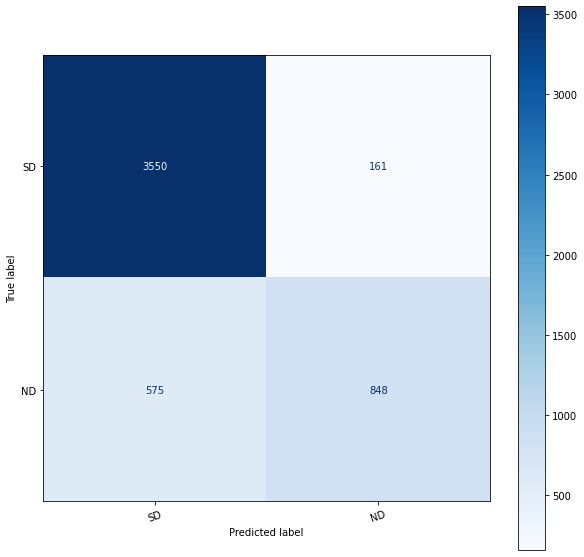

In [28]:
plot_confusion_matrix(labels, pred_labels, classes)

In [29]:
report_file_path = './report_final.json'
export_report(EXPERIMENT, 
              labels, 
              pred_labels, 
              list(classes.keys()),
              valid_loss, 
              valid_acc, 
              valid_kappa,               
              test_loss, 
              test_acc, 
              test_kappa, 
              report_file_path) 

{'ai_lab_splitter_input_1_classes_2_nn_VGG16': {'SD': {'precision': 0.8606060606060606, 'recall': 0.956615467528968, 'f1-score': 0.9060745278203165, 'support': 3711}, 'ND': {'precision': 0.8404360753221011, 'recall': 0.5959241040056219, 'f1-score': 0.6973684210526315, 'support': 1423}, 'accuracy': 0.8566419945461629, 'macro avg': {'precision': 0.8505210679640809, 'recall': 0.7762697857672949, 'f1-score': 0.801721474436474, 'support': 5134}, 'weighted avg': {'precision': 0.8550155095622206, 'recall': 0.8566419945461629, 'f1-score': 0.8482270813983424, 'support': 5134}, 'valid_acc': 0.8571428571428571, 'valid_kappa': 0.6624009300999741, 'test_acc': 0.8628653067474564, 'test_kappa': 0.6758285641088472}}


We'll then find out which predictions were incorrect and then sort these incorrect predictions by how confident our model was.

In [42]:
corrects = torch.eq(labels, pred_labels)

In [84]:
incorrect_examples = []

for image, label, prob, correct, file_name in zip(images, labels, probs, corrects, file_names):
    if not correct:
        incorrect_examples.append((image, label, prob, file_name))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot these most confident incorrect predictions.

In [89]:
def plot_most_incorrect(incorrect, classes, n_images, file_names, normalize = True):

    rows = int(np.sqrt(n_images)) 
    cols = int(np.sqrt(n_images)) -1

    fig = plt.figure(figsize = (30, 25))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs, file_name = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        
        true_class = classes[true_label if type(true_label)==int else true_label.item()]
        incorrect_class = classes[incorrect_label if type(true_label)==int else incorrect_label.item()]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})\n' \
                     f'file: {file_name}\n')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

Again, the frog that was incorrectly labelled as a cat is there with a lot of automobile/truck confusion.

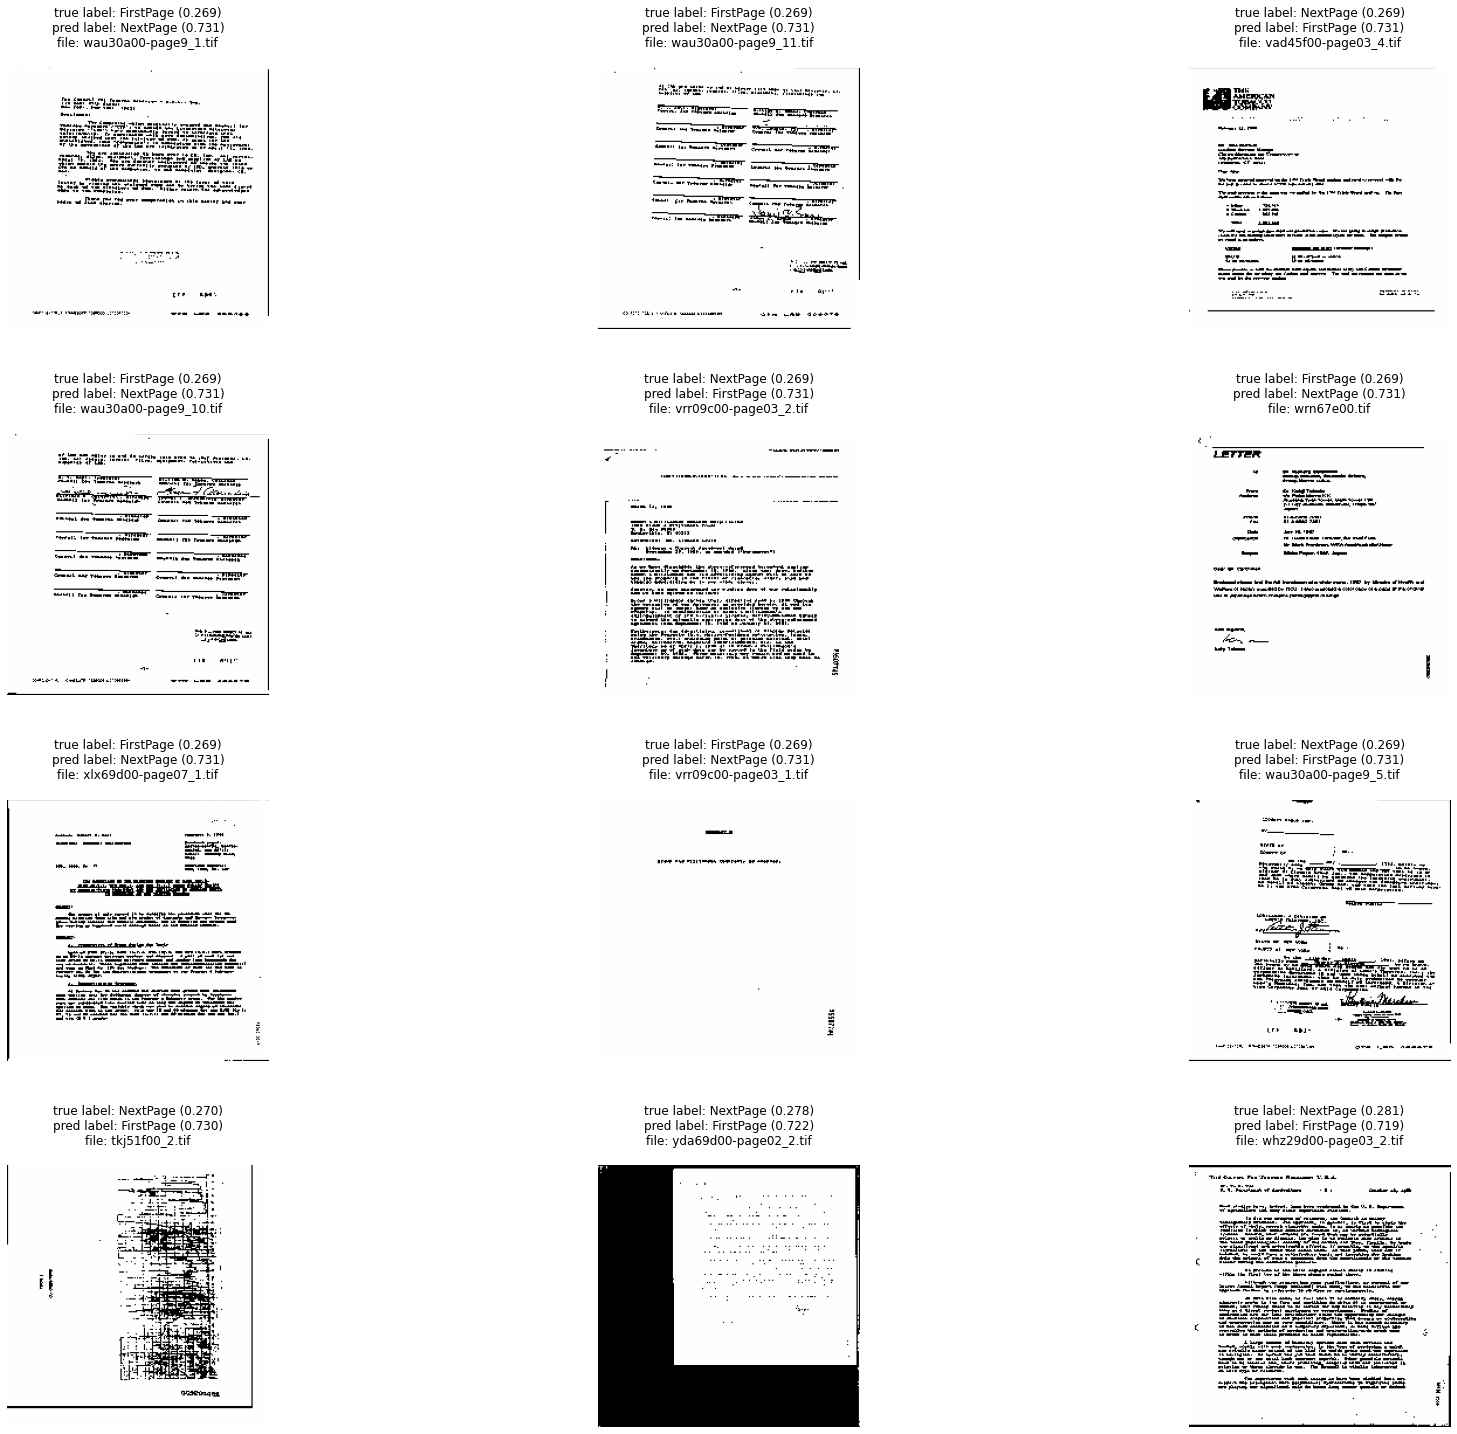

In [90]:
N_IMAGES = 36 if len(incorrect_examples) >= 36 else len(incorrect_examples)
classes = {1: 'FirstPage', 0: 'NextPage'}
plot_most_incorrect(incorrect_examples, classes, N_IMAGES, file_names)

Next up is plotting the representations of the model with PCA and then t-SNE.

We are only going to plot the output representations and not the intermediate ones here. This is because the output dimensions are two dimensional but the intermediate representations have over 25,000 dimensions and storing these in memory takes a considerably amount of RAM.

In [93]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        
        for (x, y, _) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)
        
    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

First, we gets the output representations...

In [94]:
outputs, labels = get_representations(model, train_iterator)

Next, we define a function to perform PCA on the representations and plot the PCA output.

In [95]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

In [96]:
def plot_representations(data, labels, classes, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
        
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = classes)

We can then plot the PCA representations.

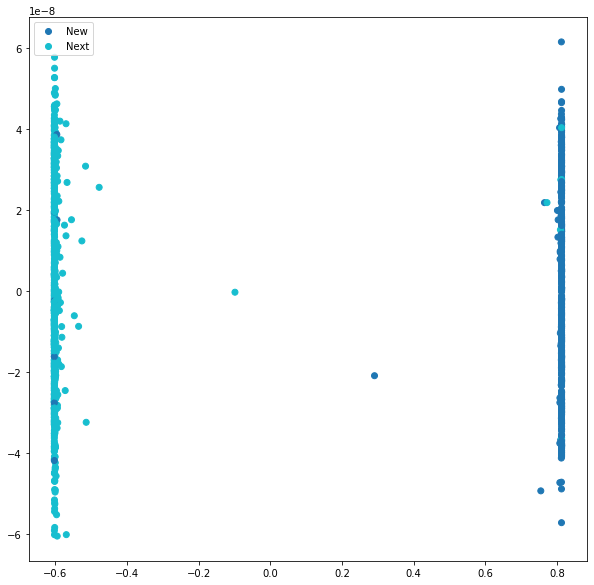

In [97]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels, ['New','Next'])

Next up is calculating the t-SNE representations.

In [98]:
def get_tsne(data, n_components = 2, n_images = None):
    
    if n_images is not None:
        data = data[:n_images]
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

The t-SNE takes a lot longer to compute compared to PCA, thus we only use a sample of the representations to calculate the t-SNE embeddings.

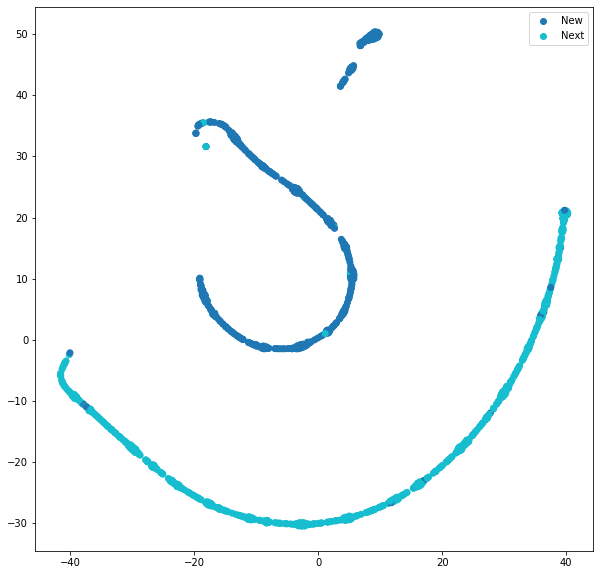

In [99]:
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, ['New','Next'], n_images = N_IMAGES)

We'll then get the filters learned by our model and plot some images with the filters applied to them.

In [100]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

We can see that the filters learned by the model do different types of edge detection, color inversion and blurring.

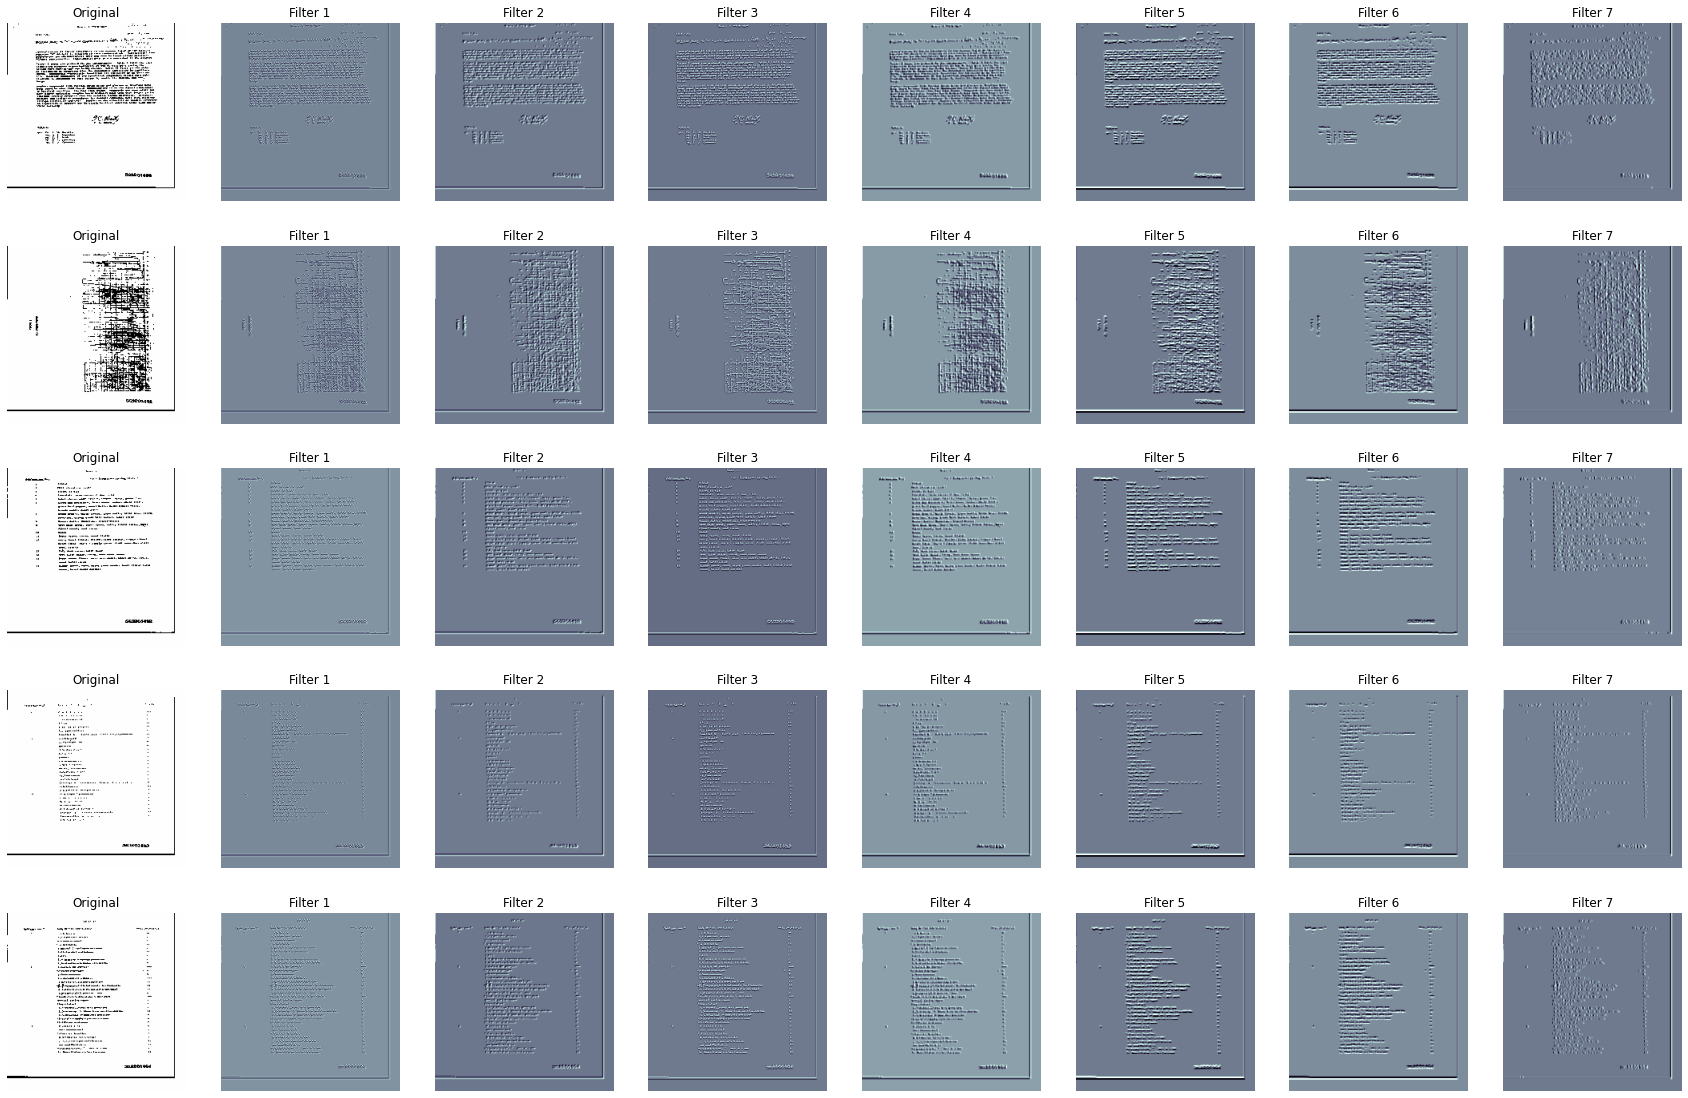

In [103]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label, _ in [valid_data[i] for i in range(N_IMAGES)]]
filters = model.features[0].weight.data

plot_filtered_images(images, filters, N_FILTERS)

We can also plot out the actual filter weights learned by the model.

In [104]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (20, 10))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')

    fig.subplots_adjust(wspace = -0.9)

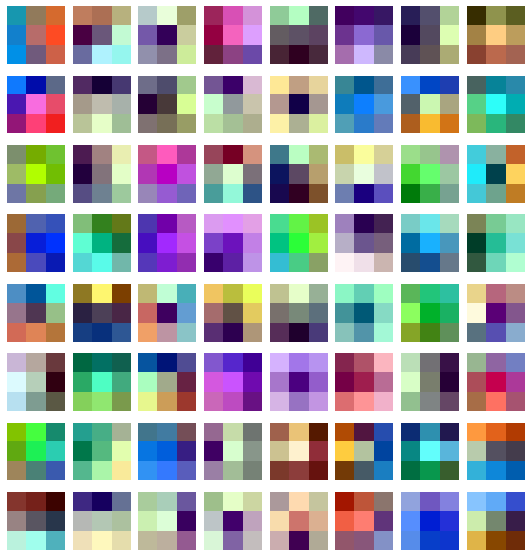

In [105]:
plot_filters(filters)